# Ranking school examination results using multivariate hierarchical models

In [82]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

In [83]:
import json 

with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)
    
with open("data/params.json") as file:
    params = json.load(file)

In [84]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)
    
for idx, item in params.items():
    params[idx] = np.array(item).reshape(-1)

In [85]:
data.keys(), init.keys(), params.keys()

(dict_keys(['Gender', 'LRT', 'M', 'N', 'R', 'school', 'School_denom', 'School_gender', 'Y', 'VR']),
 dict_keys(['theta', 'phi', 'gamma', 'beta', 'Omega', 'alpha']),
 dict_keys(['R_shape', 'School_denom_shape', 'School_gender_shape', 'Venom_shape', 'Omega_shape', 'alpha_shape']))

In [86]:
hyperparams = dict()
hyperparams["tau0"] = 1e-4
hyperparams["phi_sd_proposal"] = 1
hyperparams["theta_sd_proposal"] = 1
hyperparams["T_sd_proposal"] = [5, 2, 2, 5, 2, 5]

In [87]:
data["Omega"] = init["Omega"]
del init["Omega"]
   
init["T"] = (sp.wishart(scale = data["R"].reshape(3,3), df = 3).rvs() + 1e-6 * np.eye(3)).reshape(-1)

In [88]:
def sampler(n, data, init, params, hyperparams):
    
    # initialisation de la chaine 
    chain = dict()
    for key, param in init.items():
        chain[key] = np.zeros((n+1, param.shape[0]))
        chain[key][0, :] = param
    
    # définition des constantes
    Y = data["Y"]
    
    N = Y.shape[0]
    n_beta = init["beta"].shape[0]
    n_schools = int(data["M"])
    
    
    LRT_sum = np.sum(data["LRT"])
    tau0 = hyperparams["tau0"]
    phi_sd_proposal = hyperparams["phi_sd_proposal"]
    theta_sd_proposal = hyperparams["theta_sd_proposal"]
    T_sd_proposal = hyperparams["T_sd_proposal"]
    
    T0 = np.linalg.pinv(data["Omega"].reshape(3, 3))
    R_inv = np.linalg.pinv(data["R"].reshape(3, 3))
    
    # définition de v
    LRT = data["LRT"].reshape(-1, 1)
    VR = data["VR"].reshape(N, -1, order="F")
    Girl = data["Gender"].reshape(-1, 1)
    School_gender = data["School_gender"].reshape(N, -1, order="F")
    School_denom = data["School_denom"].reshape(N, -1, order="F")

    v = np.concatenate((LRT**2, VR[:, [1]], Girl , School_gender, School_denom), axis=1)
    
    # définition de u
    u = np.concatenate((np.ones((N, 1)), LRT, VR[:, [1]]), axis=1)
    
    # initialisation de mu et tau
    mu_current  = np.zeros(N) 
    mu1_current  = np.zeros(N) 
    mu2_current  = np.zeros(N) 
    
    # mise à jour des paramètres
    for i in range(1, n+1):
        print(i, end=" ")
        
        # mise à jour de alpha: normale
        ## calcul de tau
        theta_current = chain["theta"][i-1, :]
        phi_current = chain["phi"][i-1, :]
        tau_current = np.exp(theta_current + phi_current * LRT).flatten()
        
        ## variables intervenant dans la loi de alpha
        beta_current = chain["beta"][i-1, :]
        mu2_current = np.dot(v, beta_current) 
        mu_current = mu1_current + mu2_current
        
        gamma_current = chain["gamma"][i-1, :]
        T_current = chain["T"][i-1, :].reshape(3, 3)
        print(np.linalg.eigvals(T_current))
        
        for j in range(1, n_schools+1):
            school_j = (data["school"] == j)
            tau_j = tau_current[school_j]
            u_j = u[school_j, :]
            v_j = v[school_j, :]
            Y_j = Y[school_j]
            
            n_j = len(Y_j)
            alphaj_cov_inv = T_current
            for k in range(n_j):
                u_kj =  u[[k], :]
                alphaj_cov_inv = alphaj_cov_inv + tau_j[k] * np.dot(u_kj.T, u_kj)
            alphaj_cov = np.linalg.pinv(alphaj_cov_inv)
            
            alphaj_mean = np.dot(T_current, gamma_current)
            for k in range(n_j):
                alphaj_mean = alphaj_mean + tau_j[k] * (Y_j[k] - np.dot(beta_current, v_j[k, :])) * u[k, :]
            alphaj_mean = np.dot(alphaj_cov, alphaj_mean)
            
            alphaj_proposal = np.random.multivariate_normal(alphaj_mean, alphaj_cov)
            chain["alpha"][i,(3*(j-1)):(3*j)] = alphaj_proposal
        
        alpha_current = chain["alpha"][i, :]
        
        # mise à jour de mu_1 (car elle dépend de alpha)
        for j in range(1, n_schools + 1):
            school_j = (data["school"] == j)
            alpha_j = alpha_current[(3*(j-1)):(3*j)]
            mu1_current[school_j] = np.dot(u[school_j, :], alpha_j) 
        mu_current = mu1_current + mu2_current
        
        # mise à jour de beta: normale multivariée        
        beta_cov_inv = tau0 * np.eye(n_beta) 
        for k in range(N):
            beta_cov_inv = beta_cov_inv + tau_current[k] * np.dot(v[[k], :].T, v[[k], :])
        beta_cov = np.linalg.pinv(beta_cov_inv)
        
        
        tmp = np.zeros(v.shape)
        for k in range(N):
            j = data["school"][k]
            alpha_j = alpha_current[(3*(j-1)):(3*j)]
            tmp_k = tau_current[k] * (Y[k] - np.dot(alpha_j, u[k, :]))
            tmp_k = tmp_k * v[k, :]
            tmp[k, :] = tmp_k
        beta_mean = np.sum(tmp, axis=0)
        beta_mean = np.dot(beta_cov, beta_mean)
        
        beta_proposal = np.random.multivariate_normal(beta_mean, beta_cov)
        
        chain["beta"][i, :] = beta_proposal
        beta_current = beta_proposal
        mu2_current = np.dot(v, beta_current)
        mu_current = mu1_current + mu2_current
        
        # mise à jour de phi: mcmc 
        # phi peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"
        phi_proposal = phi_current + np.random.normal(scale=phi_sd_proposal)
        
        phi_top = - tau0 * np.power(phi_proposal, 2)
        phi_top += LRT_sum * phi_proposal
        phi_top -= np.exp(theta_current) * np.sum(
            np.exp(phi_proposal*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
        )
        phi_top *= .5
        
        phi_bottom = -tau0 * np.power(phi_current, 2)
        phi_bottom += LRT_sum * phi_current
        phi_bottom -= np.exp(theta_current) * np.sum(
            np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
        )
        phi_bottom *= .5
        
        phi_acceptance = np.exp(phi_top-phi_bottom)
        if phi_acceptance < np.random.rand():
            chain["phi"][i,:] = phi_proposal
            phi_current = phi_proposal
            tau_current = np.exp(theta_current + phi_current * LRT).flatten()
        else:
            chain["phi"][i,:] = phi_current

        
        # mise à jour de theta: mcmc 
        # theta peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"        
        theta_proposal = theta_current + np.random.normal(scale=theta_sd_proposal)
        
        theta_top = (-tau0/2) * np.power(theta_proposal, 2)
        theta_top += (N/2) * theta_proposal
        theta_top -= (np.exp(theta_proposal)/2) * np.sum(
            np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
        )
        
        theta_bottom = (-tau0/2) * np.power(theta_current, 2)
        theta_bottom += (LRT_sum/2) * theta_current
        theta_bottom -= (np.exp(theta_current)/2) * np.sum(
            np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
        ) 
        
        theta_acceptance = np.exp(theta_top-theta_bottom)
        if theta_acceptance < np.random.rand():
            chain["theta"][i,:] = theta_proposal
            theta_current = theta_proposal
            tau_current = np.exp(theta_current + phi_current * LRT).flatten()
        else:
            chain["theta"][i,:] = theta_current
        
        # mise à jour de gamma: normale
        alpha_current_sum = np.zeros(3)
        for j in range(1, n_schools+1):
            alpha_current_sum = alpha_current_sum + alpha_current[(3*(j-1)):(3*j)]
        
        gamma_cov = np.linalg.pinv(T0 + n_schools*T_current)
        gamma_mean = np.dot(gamma_cov, np.dot(T_current, alpha_current_sum))
        
        gamma_proposal = np.random.multivariate_normal(gamma_mean, gamma_cov)
        
        chain["gamma"][i, :] = gamma_proposal
        gamma_current = gamma_proposal
        
        # mise à jour de T: mcmc       
        for k, (a, b) in enumerate(((0,0), (0,1), (0,2), (1,1), (1,2), (2,2))):
            # boucle pour garantir que T reste définie positive
            while True:
                Tab = np.random.normal(T_current[a, b], scale=T_sd_proposal[k])
                T_proposal = np.copy(T_current)
         
                T_proposal[a, b] = Tab
                T_proposal[b, a] = Tab
                
                if np.all(np.linalg.eigvals(T_proposal) > 0):
                    break
            
            T_top = (n_schools-1) * np.log(np.linalg.det(T_proposal))
            T_top -= np.sum(np.diag(np.dot(R_inv, T_proposal))) 
            
            T_bottom = (n_schools-1) * np.log(np.linalg.det(T_current))
            T_bottom -= np.sum(np.diag(np.dot(R_inv, T_current))) 
            for j in range(1, n_schools+1):
                alpha_j = alpha_current[(3*(j-1)):(3*j)]
                diff_j = (gamma_current - alpha_j).reshape(-1, 1)
                T_top -= np.dot(diff_j.T, np.dot(T_proposal, diff_j))
                T_bottom -= np.dot(diff_j.T, np.dot(T_current, diff_j))
            T_top *= .5
            T_bottom *= .5
            
            T_acceptance = np.exp(T_top - T_bottom)
            
            if T_acceptance < np.random.rand():
                chain["T"][i, :] = T_proposal.flatten()
                T_current = T_proposal
            else:
                chain["T"][i, :] = T_current.flatten()
            
    return(chain)     

In [89]:
 chain = sampler(100, data, init, params, hyperparams)

1 [1.92496117e-01 1.01832320e-01 2.15283665e-05]
2 [1.92496117e-01 1.01832320e-01 2.15283665e-05]
3 

C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:136: RuntimeWarning: overflow encountered in exp
  phi_acceptance = np.exp(phi_top-phi_bottom)


[5.95601973 3.27632213 1.66952811]
4 [0.9417805  7.46353465 9.93867336]


C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:81: RuntimeWarning: covariance is not positive-semidefinite.
  alphaj_proposal = np.random.multivariate_normal(alphaj_mean, alphaj_cov)
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:209: RuntimeWarning: overflow encountered in exp
  T_acceptance = np.exp(T_top - T_bottom)


5 [ 2.48391227  6.71638369 10.33272149]
6 [14.11731285  8.89457476  4.03826195]
7 [14.57902599  9.05845626  4.0413459 ]
8 [16.47926357 12.04781304 10.47047883]


C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:162: RuntimeWarning: overflow encountered in exp
  theta_acceptance = np.exp(theta_top-theta_bottom)


9 [11.47911836 16.90472451 23.74266417]
10 [11.54596908 20.03437802 24.53219753]
11 [26.37019831 13.28651886 18.60570337]
12 [12.87055144 20.92724126 25.8928281 ]
13 [15.30296541 24.7265565  29.73404332]
14 [16.50877403 25.17092026 30.91578405]
15 [36.93117861 27.13992106 21.85011838]
16 [37.61178501 27.17565639 22.3063974 ]
17 [37.61178501 27.17565639 22.3063974 ]
18 [23.72070628 31.11379631 43.66310555]
19 [24.70841841 31.89249018 48.62273577]
20 [28.15973288 48.04255916 36.93268646]
21 [28.64458364 48.13964768 36.92618808]
22 [28.68826593 50.21473691 37.13351334]
23 [28.68872288 50.40632574 43.28915098]
24 [31.48952229 55.1283028  43.61794529]
25 [33.38222931 55.52865952 50.17065016]
26 [43.49756179 56.22284085 50.43001828]
27 [43.87896856 61.77030977 52.32570728]
28 [63.40994709 44.63792181 51.00959027]
29 [43.09332059 67.63334248 58.91527737]
30 [43.79018882 61.64389528 73.71435306]
31 [45.38723653 74.71036089 63.6271226 ]
32 [45.31316785 82.85391114 64.35506156]
33 [45.21087042 8

C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:125: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_proposal*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:131: RuntimeWarning: overflow encountered in multiply
  phi_bottom -= np.exp(theta_current) * np.sum(
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:136: RuntimeWarning: invalid value encountered in subtract
  phi_acceptance = np.exp(phi_top-phi_bottom)
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:152: RuntimeWarning: overflow encountered in multiply
  theta_top -= (np.exp(theta_proposal)/2) * np.sum(
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:158: RuntimeWarning: overflow encountered in multiply
  theta_bottom -= (np.exp(theta_current)/2) * np.sum(
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:162: RuntimeWarning: invalid value encountered in subtract
  theta_acceptance = np.exp(theta_top-the

40 [57.15487314 95.72080763 76.49298222]
41 [54.36760031 99.55849816 77.68195104]
42 [102.73208707  53.14332469  75.73263775]
43 

C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:132: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:153: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:159: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2)


[105.46877529  53.99108154  75.47973164]
44 [107.54464747  53.68940637  75.93001308]
45 [108.30000624  52.91330136  75.95075931]
46 

C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:124: RuntimeWarning: overflow encountered in multiply
  phi_top -= np.exp(theta_current) * np.sum(


[112.10510812  51.14246256  73.91649624]
47 [118.15029047  48.46232767  76.19892888]
48 [124.07850744  50.24667078  79.52243985]
49 [127.33668415  48.0608865   78.45004742]
50 [134.31966629  47.74158004  85.7398325 ]
51 [139.51835174  46.58761392  91.56622865]
52 [146.02678246  52.34528045  96.39198423]
53 [147.88424711  51.30309954  97.89190743]
54 [ 50.63853841 152.16642858 101.42861542]
55 [ 53.48002035 156.55482036 106.6266295 ]
56 [ 53.38231179 159.92469808 109.57068352]
57 [ 51.99721994 164.92065923 109.72157799]
58 [ 50.88471353 167.76096373 110.09405193]
59 [ 50.85217949 173.37857348 114.90057243]
60 [ 48.18597195 177.25485811 116.46350729]
61 [ 51.77124621 178.89618588 116.97759816]
62 [181.56063763  53.63478354 117.151543  ]
63 [ 54.53902453 188.86945655 122.62971893]
64 [ 54.53073066 190.97528124 122.97025606]
65 [191.80369016  56.54982694 123.08095215]
66 [195.29493036  60.17528037 123.70774696]
67 [197.86912405  56.84736372 124.46146993]
68 [203.35046643  62.00482096 125.1

C:\Users\hp\AppData\Local\Temp\ipykernel_5720\103652612.py:105: RuntimeWarning: overflow encountered in multiply
  tmp_k = tmp_k * v[k, :]


70 [204.26221967  62.73439163 126.47021175]
71 [204.26221967  62.73439163 126.47021175]
72 [204.26221967  62.73439163 126.47021175]
73 [204.26221967  62.73439163 126.47021175]
74 [204.26221967  62.73439163 126.47021175]
75 [204.26221967  62.73439163 126.47021175]
76 [204.26221967  62.73439163 126.47021175]
77 [204.26221967  62.73439163 126.47021175]
78 [204.26221967  62.73439163 126.47021175]
79 [204.26221967  62.73439163 126.47021175]
80 [204.26221967  62.73439163 126.47021175]
81 [204.26221967  62.73439163 126.47021175]
82 [204.26221967  62.73439163 126.47021175]
83 [204.26221967  62.73439163 126.47021175]
84 [204.26221967  62.73439163 126.47021175]
85 [204.26221967  62.73439163 126.47021175]
86 [204.26221967  62.73439163 126.47021175]
87 [204.26221967  62.73439163 126.47021175]
88 [204.26221967  62.73439163 126.47021175]
89 [204.26221967  62.73439163 126.47021175]
90 [204.26221967  62.73439163 126.47021175]
91 [204.26221967  62.73439163 126.47021175]
92 [204.26221967  62.73439163 12

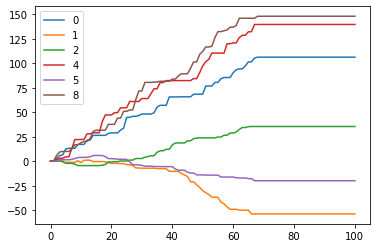

In [90]:
fig, ax = plt.subplots()
for i in (0, 1, 2, 4, 5, 8):
    ax.plot(chain["T"][:, i], label=i)
plt.legend()

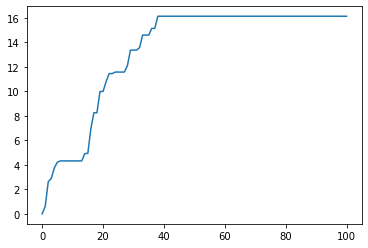

In [91]:
plt.plot(chain["theta"])

SyntaxError: invalid syntax (1483605644.py, line 4)